### Table of Contents

1. [Context](#1)
2. [Dataset analyzing](#2)
3. [Data Augmentation](#3)
4. [Data Formatting & Model Building](#4)
5. [Model Performance & Discussing Results](#5)
    

# **1. Context** <a class="anchor" id="1"></a>
The purpose of this project is to classify images from the “Natural human face dataset” using a pre-trained deep convolutional neural network (CNN) model such as **VGG16**, and transfer learning techniques.  Only three emotion categories are being used: fear, happiness, and sadness, with 160 images per class. The dataset will be split into a training set of 80% of the images and a test set of 20% of the images.

In [28]:
#Necessary imports

import seaborn as sns
import csv
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics

from keras.preprocessing import image
from keras import datasets, layers, models,regularizers
from keras.layers import Dense,Conv2D,MaxPooling2D,Conv2DTranspose,UpSampling2D,Flatten,Reshape,BatchNormalization,GlobalAveragePooling2D,Input
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import EarlyStopping


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2.Dataset Analysis** <a class="anchor" id="2"></a>




In [3]:
train_fear_path = "/content/drive/MyDrive/train/fear/"
train_happiness_path = "/content/drive/MyDrive/train/happiness/"
train_sadness_path = "/content/drive/MyDrive/train/sadness/"

#Loading the data
DF=[]
labels=[]

dirs=[train_fear_path,train_happiness_path,train_sadness_path]

for path in dirs:
    for images in os.listdir(path):
        img = cv2.imread(path+images)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(224,224))
        DF.append(img)
        local_label = ''
        if path==train_fear_path:
          local_label = 'fear'
        elif path==train_happiness_path:
          local_label = 'happiness'
        else:
          local_label = 'sadness'

        labels.append(local_label)



In [4]:
data_label=pd.DataFrame(labels)
data_label.head()

,0
0,fear
1,fear
2,fear
3,fear
4,fear


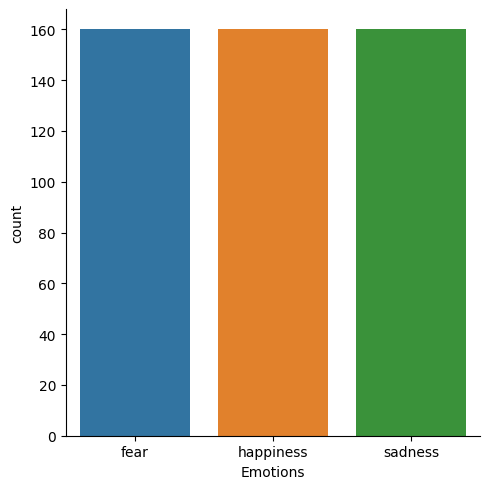

In [5]:
#Plotting the labels
sns.catplot(x=data_label.columns[0], kind='count', data=data_label)
plt.xlabel("Emotions")
plt.show()

In [6]:
data_label.shape

(480, 1)

**Observation:** Although the data is perfectly balanced, the size of the training set is too small to obtain good results (480 rows). To address this issue, we plan to use **data augmentation** techniques to increase the size of our training set. This should help to improve the performance of our model by providing more diverse examples for training. We will implement these techniques in the next cell.

# **3. Data Augmentation** <a class="anchor" id="3"></a>




In [7]:
# Creating an instance of the Image Generator
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [8]:
# Reloading the augmented data
DF=[]
labels=[]
for path in dirs:
    for images in os.listdir(path):
        img = cv2.imread(path+images)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(224,224))
        DF.append(img)
        local_label = ''
        if path==train_fear_path:
          local_label = 'fear'
        elif path==train_happiness_path:
          local_label = 'happiness'
        else:
          local_label = 'sadness'

        labels.append(local_label)

        # Data Augmentation
        img = img.reshape((1,) + img.shape)
        augmented_images = datagen.flow(img, batch_size=1)
        for i in range(9):
          batch = augmented_images.next()
          image = batch[0].astype('uint8')
          DF.append(image)
          labels.append(local_label)

print("The new number of rows: "+str(len(labels)))



The new number of rows: 4800


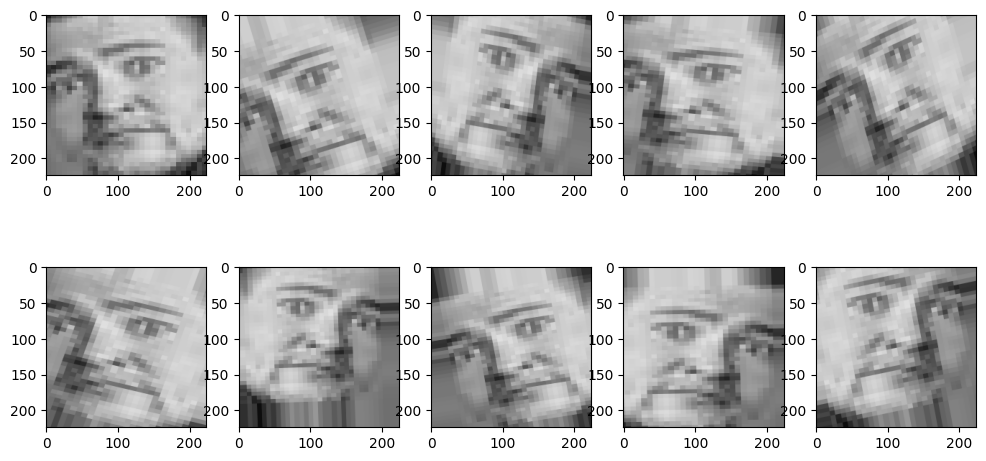

<Figure size 1000x400 with 0 Axes>

In [9]:
# An example of data augmentation results

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
plt.figure(figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    if i < 10:
        ax.imshow(DF[i])
    
plt.tight_layout()
plt.show()

**Note:** As we now have a significant amount of data for training our model, it is important to **shuffle** the images to prevent any patterns of order that could lead to false assumptions. By randomly rearranging the order of the images, we can ensure that our model is learning from a diverse and representative sample of data.

In [10]:
shuffle_indices = np.random.permutation(len(DF)).astype(int)
DF = [DF[i] for i in shuffle_indices]
labels = [labels[i] for i in shuffle_indices]

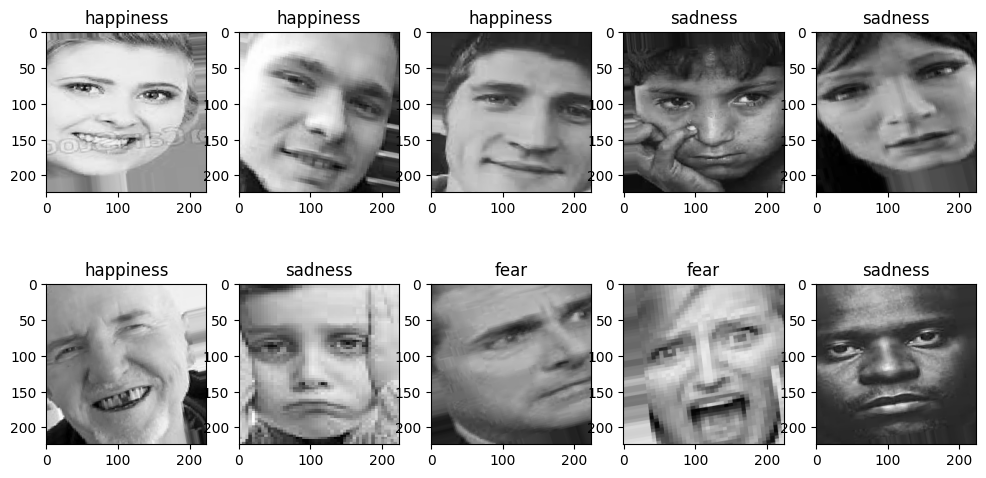

<Figure size 1000x400 with 0 Axes>

In [11]:
# Checking that the data is correctly shuffled
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
plt.figure(figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    if i < 10:
        ax.imshow(DF[i])
        ax.set_title(labels[i])
    
plt.tight_layout()
plt.show()

In [12]:
# We're not augmenting the test data
test_fear_path = "/content/drive/MyDrive/test/fear/"
test_happiness_path = "/content/drive/MyDrive/test/happiness/"
test_sadness_path = "/content/drive/MyDrive/test/sadness/"


DF_test=[]
labels_test=[]

dirs_test=[test_fear_path,test_happiness_path,test_sadness_path]

for path in dirs_test:
    for images in os.listdir(path):
        img = cv2.imread(path+images)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(224,224))
        
        
        DF_test.append(img)
        local_label = ''
        if path==test_fear_path:
          local_label = 'fear'
        elif path==test_happiness_path:
          local_label = 'happiness'
        else:
          local_label = 'sadness'

        labels_test.append(local_label)


# **4. Data Formatting & Model Building** <a class="anchor" id="4"></a>

In [13]:
label_df=pd.DataFrame(labels)
label_test_df=pd.DataFrame(labels_test)

In [14]:
# Hot Encoding the target column since we can't fit with string values
label_df=pd.get_dummies(label_df)
label_test_df=pd.get_dummies(label_test_df)
label_df.head()

,0_fear,0_happiness,0_sadness
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1


In [15]:
#Converting the model inputs into arrays
X_train=np.array(DF)
y_train=np.asarray(label_df)

X_test=np.array(DF_test)
y_test=np.asarray(label_test_df)

In [33]:
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Implementing the model
model2=keras.Sequential([base_model,
                        layers.Flatten(),
                        layers.Dense(128,activation="relu"),
                         layers.Dense(64,activation="relu"),
                        layers.Dense(3,activation="softmax")])
model2.summary() 


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               3211392   
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 3)                 195       
                                                                 
Total params: 17,934,531
Trainable params: 3,219,843
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
# Stop the training if there is no improving after 3 epochs 
early_stop = EarlyStopping(monitor='val_accuracy', patience=3)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=7,
                    validation_data=(X_test, y_test),callbacks=[early_stop])


Epoch 1/7
150/150 [==============================] - 22s 135ms/step - loss: 1.9158 - accuracy: 0.6673 - val_loss: 1.2838 - val_accuracy: 0.6667
Epoch 2/7
150/150 [==============================] - 21s 138ms/step - loss: 0.1703 - accuracy: 0.9421 - val_loss: 1.4929 - val_accuracy: 0.6667
Epoch 3/7
150/150 [==============================] - 20s 131ms/step - loss: 0.0497 - accuracy: 0.9840 - val_loss: 1.7914 - val_accuracy: 0.6583
Epoch 4/7
150/150 [==============================] - 19s 129ms/step - loss: 0.0126 - accuracy: 0.9981 - val_loss: 1.9341 - val_accuracy: 0.6750
Epoch 5/7
150/150 [==============================] - 20s 132ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.1433 - val_accuracy: 0.6833
Epoch 6/7
150/150 [==============================] - 20s 133ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.0858 - val_accuracy: 0.6833
Epoch 7/7
150/150 [==============================] - 20s 132ms/step - loss: 9.2119e-04 - accuracy: 1.0000 - val_loss: 2.1280 - val_accur

# **5. Model Performance & Discussing Results** <a class="anchor" id="5"></a>

In [35]:
model2.evaluate(X_test,y_test)

4/4 [==============================] - 1s 129ms/step - loss: 2.1280 - accuracy: 0.6833


[2.1279706954956055, 0.6833333373069763]

In [36]:
pred=model2.predict(X_test)

# reducing the labels dimension because the confusion matrix doesn't accept multidimension labels (since we're using hot encoding)

for j in pred:
  for l in range(len(j)):
    if j[l]==max(j):
      j[l]=1
    else: j[l]=0

arg_preds=[]
args_test=[]
for p in pred:
  arg_preds.append(np.argmax(p))

for t in y_test:
  args_test.append(np.argmax(t))


4/4 [==============================] - 1s 139ms/step


In [37]:
confusion_matrix = metrics.confusion_matrix(args_test, arg_preds)

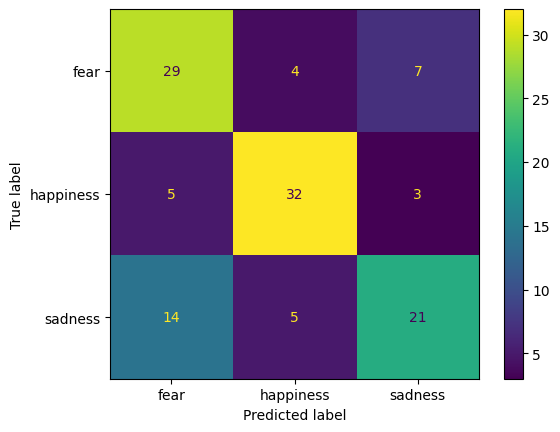

In [38]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["fear", "happiness","sadness"])
cm_display.plot()
plt.show()

**Conslusion:** Based on the results, the model seems to perform well in identifying happy facial expressions, but shows some difficulty in distinguishing between fear and sadness. This limitation is likely due to the insufficient amount of data available, and the images quality.